In [1]:
from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=50$

In [4]:
m = n = 50
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 1

mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=7.0456e+01


In [5]:
Z_star_1, Z_star_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [6]:
Y_star_torch = torch.tensor(Y_star, dtype=A.dtype, device=device)
Z_star_1_torch = torch.tensor(Z_star_1, dtype=A.dtype, device=device)
Z_star_2_torch = torch.tensor(Z_star_2, dtype=A.dtype, device=device)
pd_residuals_infty_ball(A, B, Y_star_torch, Z_star_1_torch, Z_star_2_torch, G1, G2, beta, mu_reg, abs_tol=1e-4)

(8.807582162262406e-06,
 1.761340298422639e-07,
 1.425727458747669e-06,
 1.1516833190435656e-07)

In [7]:
Y0, res_y = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
(Z1_0, Z2_0), res_z = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=1000, diag_scaling=True)
res_y["res"], res_z["res"]

(1.1314976059431856e-06, 1.2209935812279581e-06)

In [8]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [9]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [10]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-50.294015285787395), -50.29401397705078, 
cvxpy constraint violation: 8.344650268554688e-07


In [11]:
residuals = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=1000, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -4.968620e+01  1.671159e-02
rehpdhg       -4.968620e+01  1.671159e-02
pdhg ds       -4.991921e+01  8.918762e-03
rehpdhg ds    -4.987275e+01  7.949591e-03
ada rehpdhg   -4.912518e+01  4.869342e-03
ada rehpdhg ds  -4.952284e+01  5.892873e-03


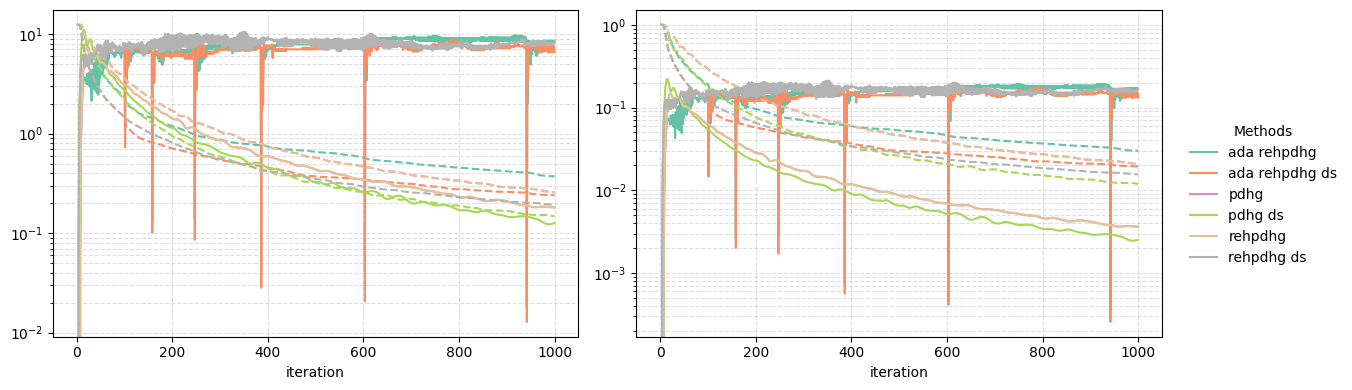

In [12]:
plot_residuals_compare(residuals, dpi=100, dual_scale=True,
                    #    abs_ylim=(1e-3, 1e-1), rel_ylim=(1e-3, 2)
                       )

#  $m=n=1000$

In [13]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=3.7619e+00


In [14]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=3.7619e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.733986e-01  4.126040e-01
rehpdhg       -9.733986e-01  4.126040e-01
pdhg ds       -9.847261e-01  4.086342e-01
rehpdhg ds    -9.931639e-01  5.904113e-02
ada rehpdhg   -9.634619e-01  4.639772e-02
ada rehpdhg ds  -9.762530e-01  3.827531e-02
beta=0.0005, lamb_max=3.7619e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.933907e-01  7.130659e-01
rehpdhg       -4.933907e-01  7.130659e-01
pdhg ds       -4.961708e-01  6.958204e-01
rehpdhg ds    -5.049765e-01  8.089042e-02
ada rehpdhg   -4.917438e-01  6.277724e-02
ada rehpdhg ds  -4.947844e-01  5.943135e-02
beta=0.0001, lamb_max=3.7619e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -1.573171e-02  0.000000e+00
rehpdhg       -1.573171e-02  0.000000e+00
pdhg ds       -9.952934e-02  3.089948e+00
rehpdhg ds    -1.08846

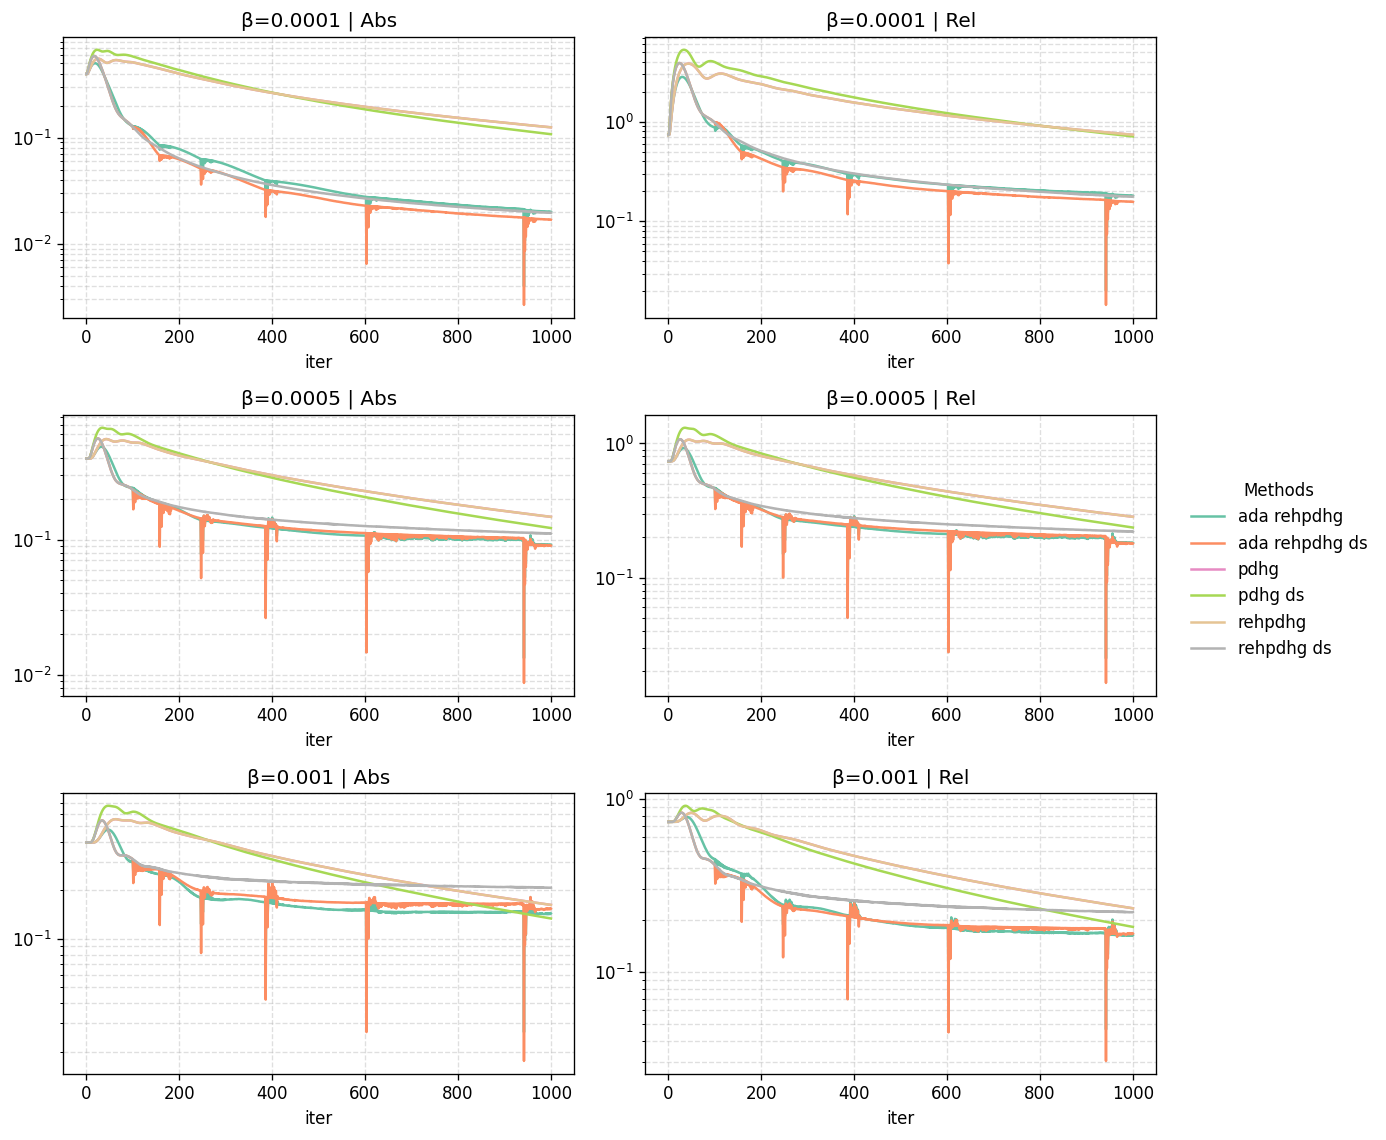

In [15]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

#  $m=n=1000$

In [16]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9972e+00


In [17]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()
 
    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -7.853480e-02  9.468994e-02
rehpdhg       -7.853480e-02  9.468994e-02
pdhg ds       -8.681911e-02  8.471757e-02
rehpdhg ds    -8.569273e-02  3.298412e-02
ada rehpdhg   -6.067939e-02  2.159043e-02
ada rehpdhg ds  -7.479577e-02  1.687247e-02
beta=0.0005, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.411023e-02  1.370627e-01
rehpdhg       -4.411023e-02  1.370627e-01
pdhg ds       -4.644467e-02  1.339411e-01
rehpdhg ds    -3.478515e-02  1.689961e-01
ada rehpdhg   -4.068409e-02  2.744997e-02
ada rehpdhg ds  -4.346610e-02  2.304423e-02
beta=0.0001, lamb_max=9.9972e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -9.730981e-03  4.342030e-01
rehpdhg       -9.730981e-03  4.342030e-01
pdhg ds       -9.848025e-03  4.138501e-01
rehpdhg ds    -9.93064

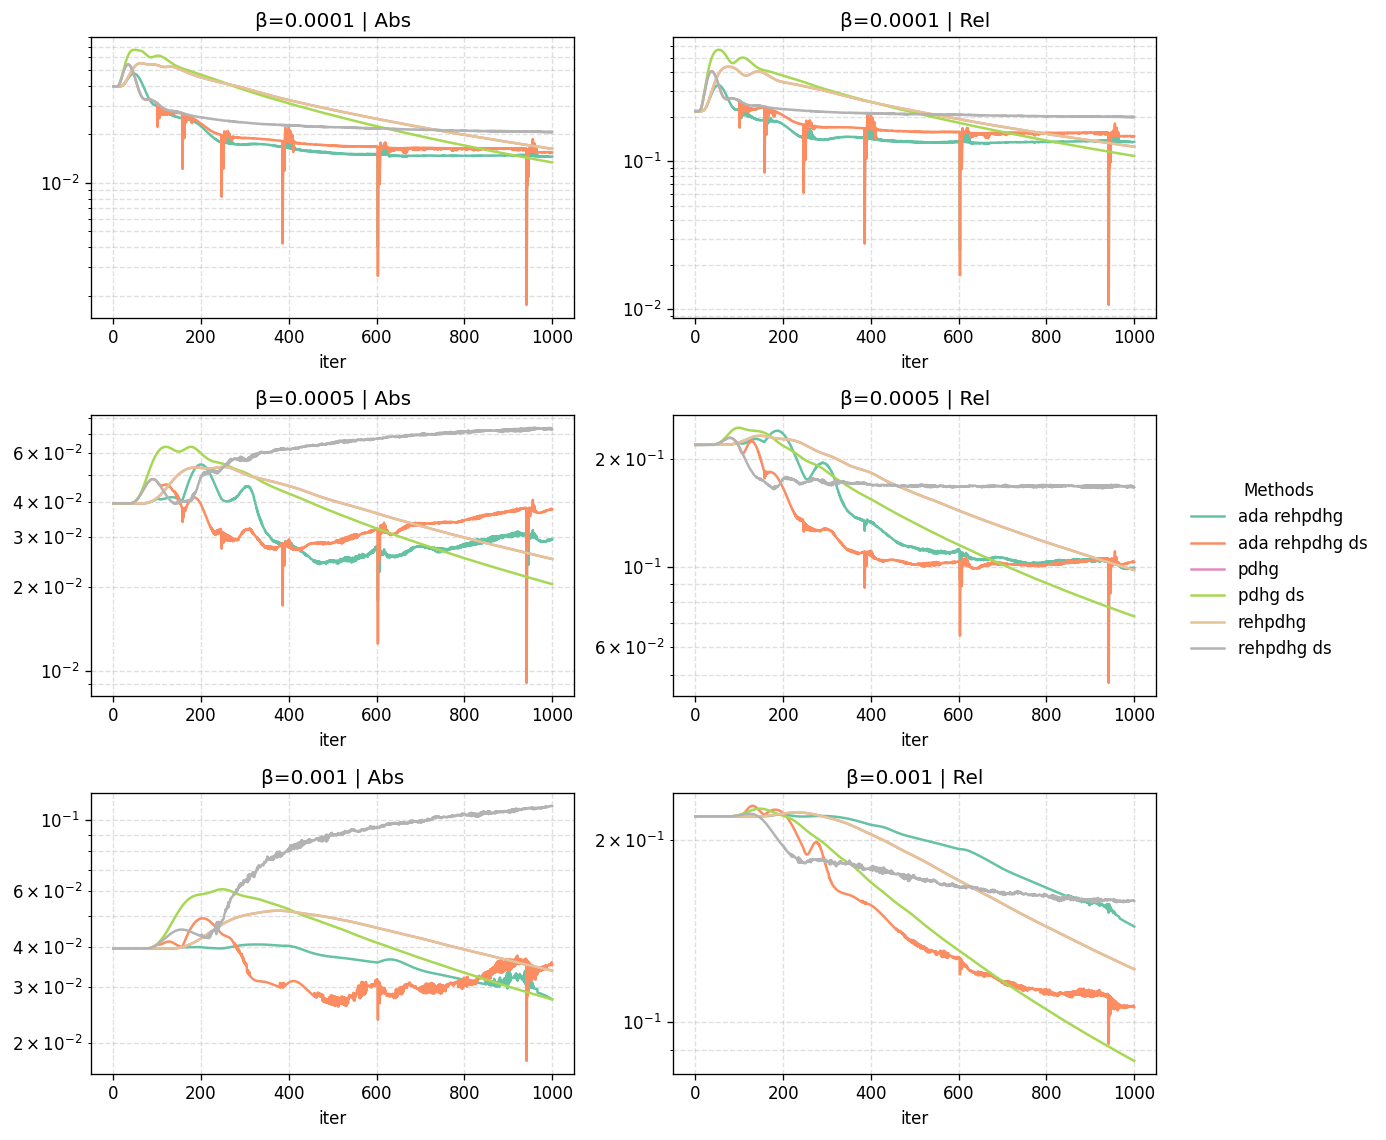

In [18]:
_ = plot_residuals_grid_by_param(residuals,  param_name='beta')